# Lab 3: Stochastic Multi-Armed Bandits

The code in this lab is inspired by the [Pyma bandit library](https://www.di.ens.fr/~cappe/Code/PymaBandits/) by O. Cappé and A. Garivier and the [SMPyBandit library](https://github.com/SMPyBandits/SMPyBandits) of Lilian Besson.

In [1]:
## EXTRACT Imports

# Make sure that the utils/ directory is accessible:
import sys
sys.path.insert(0, './utils')

import numpy as np
from matplotlib import pyplot as plt
import time

# Bandit specific functions and classes 
import Arms as arm
from StochasticBandit import *
from BanditTools import * 
import BanditBaselines as alg

## Task 0: Enter your ID

Don't forget to enter your email address in the box below. 

In [2]:
## EXTRACT ID

# TODO replace the following Email with your own
    
info = {
        'Email' : 'yannis.kedadry@polytechnique.edu',
        'Alias' : 'yKedadry', # (change this in case you want to identify yourself on the leaderboard)
}

## Part I) Understanding the experimental setup with naive bandit strategies


### 1) Creating a bandit environnement

Different arm classes are defined in `Arms.py`. To define a multi-armed bandit (a `MAB` object), you need to input a list of such arms. Some functions in `StochasticBandits.py` also define directly some particular MAB objects. 


In [3]:
nbArms = 3
bandit1 = MAB([arm.Bernoulli(0.2), arm.Gaussian(3, 1), arm.TruncatedExponential(2, 1)])
bandit2 = BernoulliBandit([0.3, 0.4, 0.5]) # directly creates a Bernoulli bandit from a vector of means

print("The means of bandit instance 1 are", bandit1.means)
print("The means of bandit instance 2 are", bandit2.means)



The means of bandit instance 1 are [0.2, 3, 0.43233235838169365]
The means of bandit instance 2 are [0.3, 0.4, 0.5]


### 2) Executing a simple bandit strategy

The function given below executes one bandit algorithm on one MAB instance. 

In [4]:
## EXTRACT 

def OneBanditOneLearnerOneRun(bandit, learner, timeHorizon):
    """
    Run a bandit strategy (learner) on a MAB instance (bandit) for (timeHorizon) time steps
    output : sequence of arms chosen, sequence of rewards obtained
    """
    selections = []
    rewards = []
    learner.clear() # reset previous history
    for t in range(timeHorizon):
        arm = learner.chooseArmToPlay()
        reward = bandit.generateReward(arm)
        learner.receiveReward(arm, reward)
        # Update statistics
        selections.append(arm)
        rewards.append(reward)
    return selections, rewards
    
def CumulativeRegret(bandit,selections):
    """Compute the pseudo-regret associated to a sequence of arm selections"""
    return np.cumsum(max(bandit.means)*np.ones(len(selections)) - np.array(bandit.means)[selections])

For the moment, we implemented two naive bandit strategies : the greedy strategy (or Follow-the-Leader, `FTL`) and a strategy that explores arms uniformly at random (`UniformExploration`). Such strategies (as the one you will implement) are defined as objects in `BanditsBaselines.py`. Below we run `FTL` on one of the bandit instances defined above, and visualize its behavior.

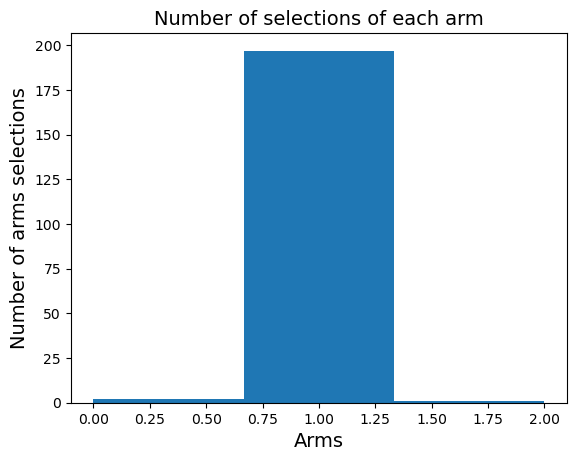

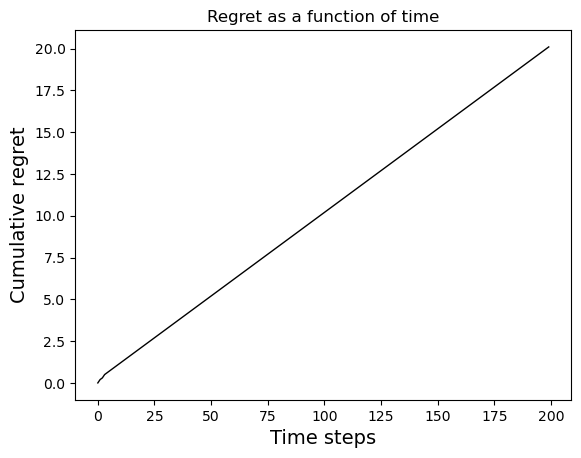

In [5]:
timeHorizon = 200
bandit = bandit2
learner = alg.FTL(nbArms)

selections, rewards = OneBanditOneLearnerOneRun(bandit, learner, timeHorizon)
regret = CumulativeRegret(bandit, selections)

# Visualize results (on one run) 

# Histogram of the number of arms selections
plt.clf()
plt.xlabel("Arms", fontsize=14)
plt.ylabel("Number of arms selections", fontsize=14)
plt.hist(selections, max(selections) + 1)
plt.title("Number of selections of each arm", fontsize=14)
# plt.savefig('./Figure/test'+ learner.name() + '.pdf')

# Cumulative regret as a function of time
plt.figure(2)
plt.clf()
plt.xlabel("Time steps", fontsize=14)
plt.ylabel("Cumulative regret", fontsize=14)
plt.title("Regret as a function of time")
plt.plot(range(timeHorizon), regret, 'black', linewidth=1)
 

### 3) Comparing two (bad) learners on one run

We now compare pure exploration and pure exploitation on a single run. If you run this code multiple time, you will have very different results.

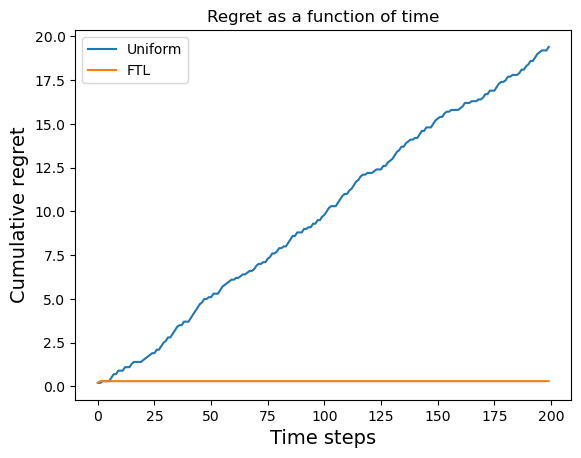

In [6]:
learner1 = alg.UniformExploration(nbArms)
learner2 = alg.FTL(nbArms)

# Run the two learners
selections, rewards = OneBanditOneLearnerOneRun(bandit, learner1, timeHorizon)
regret1 = CumulativeRegret(bandit, selections)
selections, rewards = OneBanditOneLearnerOneRun(bandit, learner2, timeHorizon)
regret2 = CumulativeRegret(bandit, selections)

# Compare their regret
plt.xlabel("Time steps", fontsize=14)
plt.ylabel("Cumulative regret", fontsize=14)
plt.title("Regret as a function of time")
plt.plot(range(0, timeHorizon), regret1,label=learner1.name())
plt.plot(range(0, timeHorizon), regret2,label=learner2.name())
plt.legend()

### 4) Comparison averaged over multiple runs

The regret is defined as an **expectation**, so we need several runs to **estimate** its value. We can also take a look at the distribution of the pseudo-regret. The function below gathers results accross multiple runs.

In [7]:
## EXTRACT

def OneBanditOneLearnerMultipleRuns(bandit, learner, timeHorizon, N_exp, tsave=[]):
    if (len(tsave) == 0):
        tsave = np.arange(timeHorizon)
    savedTimes = len(tsave)
    Regret = np.zeros((N_exp, savedTimes)) # Store the regret values on different runs
    for n in range(N_exp):
        np.random.seed()
        selections, rewards = OneBanditOneLearnerOneRun(bandit, learner, timeHorizon)
        regret_one_run = CumulativeRegret(bandit, selections)
        Regret[n, :] = np.array(regret_one_run)[tsave] # Store a sub-sampling of the cumulative regret
    return Regret

#### a) For one algorithm (FTL)

In [8]:
N_exp = 200
timeHorizon = 200
tsave = np.arange(1, timeHorizon, 10)
Regret = OneBanditOneLearnerMultipleRuns(bandit, learner2, timeHorizon, N_exp, tsave)

One can start by displaying the mean regret and some quantiles. 

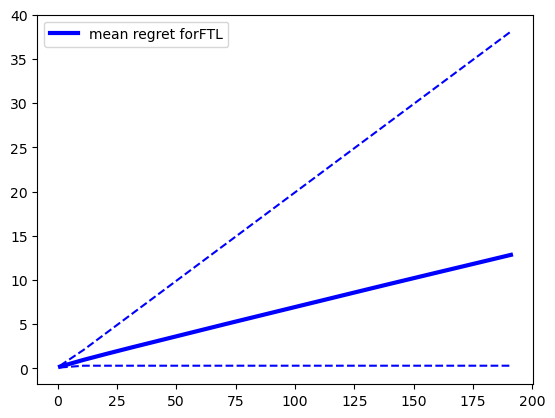

In [9]:
meanRegret = np.mean(Regret, 0)
upperQuantile = np.quantile(Regret, 0.95, 0) # requires numpy 1.15
lowerQuantile = np.quantile(Regret, 0.05, 0)

plt.clf()
plt.plot(tsave, meanRegret, linewidth=3.0, color="b", label="mean regret for"+learner2.name())
plt.plot(tsave, upperQuantile, linestyle="dashed", color="b")
plt.plot(tsave, lowerQuantile, linestyle="dashed", color="b")
plt.legend()


To highlight the variability of the regret, one can also look at the histogram of the value of $R_T$.

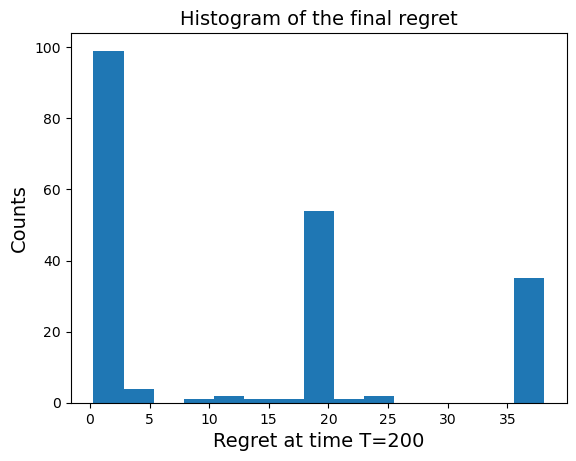

In [10]:
FinalRegret = Regret[:, len(tsave)-1]
plt.clf()
plt.xlabel("Regret at time T="+str(timeHorizon), fontsize=14)
plt.ylabel("Counts", fontsize=14)
plt.hist(FinalRegret, 15)
plt.title("Histogram of the final regret", fontsize=14)
plt.show()


#### b) FTL versus Uniform

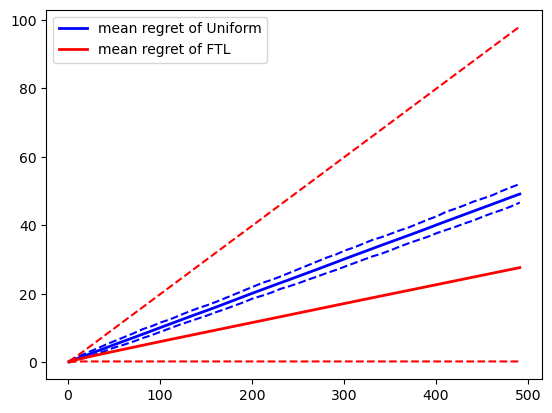

In [11]:
N_exp = 200
timeHorizon = 500
tsave = np.arange(1, timeHorizon, 10)

Regret1 = OneBanditOneLearnerMultipleRuns(bandit, learner1, timeHorizon, N_exp, tsave)
Regret2 = OneBanditOneLearnerMultipleRuns(bandit, learner2, timeHorizon, N_exp, tsave)

plt.clf()
plt.plot(tsave, np.mean(Regret1, 0), linewidth=2.0, color="b", label="mean regret of "+learner1.name())
plt.plot(tsave, np.quantile(Regret1, 0.95, 0), tsave, np.quantile(Regret1,0.05,0), linestyle="dashed", color="b")
plt.plot(tsave, np.mean(Regret2, 0), linewidth=2.0, color="r", label="mean regret of "+learner2.name())
plt.plot(tsave, np.quantile(Regret2, 0.95, 0), tsave, np.quantile(Regret2,0.05,0), linestyle="dashed", color="r")
plt.legend()
plt.show()

As you can see, both algorithms have **linear regret**, although the pseudo-regret of FTL has a much higher variance. You are now ready to try smarter algorithms!

## Part II) The UCB1 algorithm

The UCB1 algorithm is proposed by [Auer et al](https://homes.di.unimi.it/~cesabian/Pubblicazioni/ml-02.pdf) for bandit instances with bounded rewards (in $[0,1]$ to fix the ideas). One can extend it to depend on some parameter $\alpha$: 

$$A_{t} = \underset{a}{\text{argmax}} \left[\hat{\mu}_a(t-1) + \sqrt{\frac{\alpha \log(t)}{N_a(t-1)}}\right],$$
where $\hat{\mu}_a(t)$ is the empirical mean of arm $a$ after $t$ rounds and $N_a(t)$ is the number of selections of arm $a$ till that time. 

UCB1 was originally proposed with $\alpha = 2$. Its analysis was later refined to allow for $\alpha > 1/2$ (see [here](http://sbubeck.com/Bubeckthesis.pdf) or [here](https://hal.archives-ouvertes.fr/hal-00738209/file/klucb.pdf)). 

Note also that some early versions of UCB have $\log(1/\delta)$ for some value of $\delta$ depending on the horizon (typically $\delta = 1/n^2$) instead of $\log(t)$. 

### Task 1. Implement UCB($\alpha$).


In [12]:
## EXTRACT Task 1 (UCB)

class UCB:
    """UCB1 with parameter alpha"""
    def __init__(self, nbArms, alpha=1/2):
        # TODO 
        self.nbArms = nbArms
        self.alpha = alpha
        self.clear()

    def clear(self):
        # TODO 
        self.nbDraws = np.zeros(self.nbArms)
        self.cumRewards = np.zeros(self.nbArms)
        self.t = 0
        self.ucb = np.full(self.nbArms, np.inf)

    def updateArm(self, arm):
        ua = self.cumRewards[arm] / self.nbDraws[arm]
        self.ucb[arm] = ua + np.sqrt(self.alpha * np.log(self.t) / self.nbDraws[arm])
    
    def chooseArmToPlay(self):
        # TODO 
        return np.argmax(self.ucb)
        

    def receiveReward(self, arm, reward):
        # TODO 
        self.cumRewards[arm] += reward
        self.nbDraws[arm] += 1
        self.t += 1
        self.updateArm(arm)
        
    def name(self):
        return "UCB"

### Task 1 (continued). Pick a bounded bandit instance of your choice, and run UCB. Is the regret still linear?

In [55]:
# bandit = TODO 
bandit = BernoulliBandit([0.3, 0.4, 0.5])

The arms means are [0.3, 0.4, 0.5]


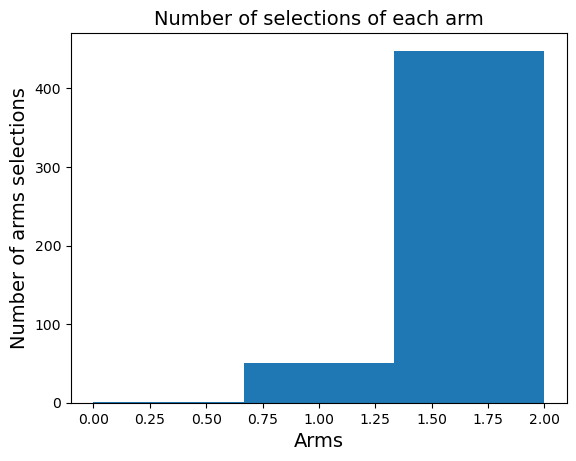

In [56]:
print("The arms means are", bandit.means)

# One run
learner = UCB(3, 0.5)
selections,rewards = OneBanditOneLearnerOneRun(bandit, learner, 500)

plt.xlabel("Arms", fontsize=14)
plt.ylabel("Number of arms selections", fontsize=14)
plt.hist(selections, max(selections)+1)
plt.title("Number of selections of each arm", fontsize=14)
plt.show()

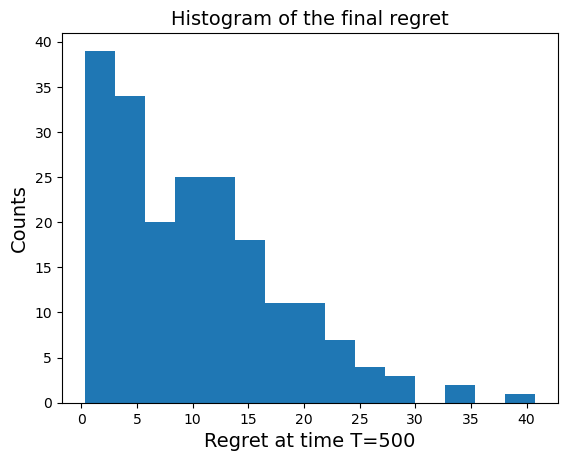

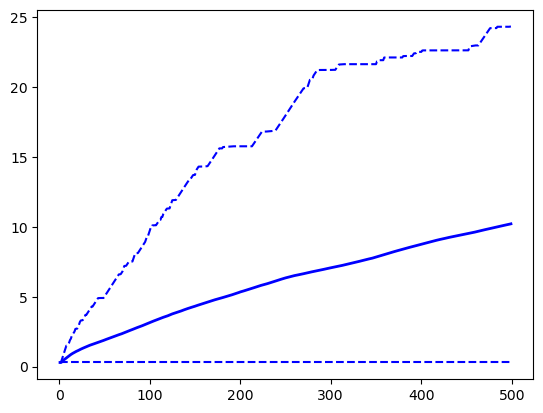

In [57]:
# Multiple runs
tsave = np.arange(1, timeHorizon, 1)
Regret = OneBanditOneLearnerMultipleRuns(bandit, UCB(3), 500, 200, tsave)

FinalRegret = Regret[:, len(tsave)-1]
plt.xlabel("Regret at time T="+str(timeHorizon), fontsize=14)
plt.ylabel("Counts", fontsize=14)
plt.hist(FinalRegret, 15)
plt.title("Histogram of the final regret", fontsize=14)

plt.figure()
plt.plot(tsave, np.mean(Regret,0), linewidth=2.0, color="b", label="Mean regret of UCB")
plt.plot(tsave, np.quantile(Regret, 0.95, 0), tsave, np.quantile(Regret,0.05,0), linestyle="dashed", color="b")
plt.show()

This looks much safer than FTL! The regret of UCB is logarithmic.

### Task 1 (continued). Influence of the parameter $\alpha$

On a fixed bandit problem, run UCB with several values for the parameter $\alpha$, and find the best value for this problem. 

In [13]:
### TODO 
def test_ucb_multiple_alpha(start, stop, num_alphas):
    bandit = BernoulliBandit([0.3, 0.4, 0.5])
    nbArms = 3
    regrets = {}
    
    N_exp = 100
    timeHorizon = 300
    tsave = np.arange(1, timeHorizon, 1)
    
    alphas = np.linspace(start, stop, num=num_alphas)
    
    for alpha in alphas:
        learner = UCB(nbArms, alpha)
        Regret = OneBanditOneLearnerMultipleRuns(bandit, learner, timeHorizon=timeHorizon, N_exp=N_exp, tsave=tsave)
        FinalRegret = Regret[:, -1]
        regrets[alpha] = np.mean(FinalRegret)

    best_alpha = min(regrets, key=lambda k: regrets[k])
    print("Best alpha:", best_alpha)
    print("Mean final regrets for the best alpha:", regrets[best_alpha])

    alphas_array = np.array(alphas)
    mean_regrets = np.array([regrets[alpha] for alpha in alphas])

    plt.plot(alphas_array, mean_regrets, marker='o', linestyle='-', color='b')
    plt.xlabel("Alphas", fontsize=14)
    plt.ylabel("Mean Final Regrets", fontsize=14)
    plt.title("UCB Performance for Different Alphas", fontsize=16)
    plt.show()

Best alpha: 1.0101010101010102
Mean final regrets for the best alpha: 10.383999999999988


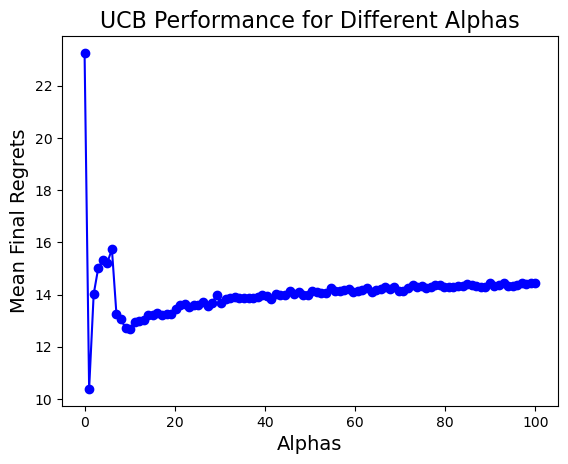

In [82]:
test_ucb_multiple_alpha(0, 100, 100)

Best alpha: 0.30303030303030304
Mean final regrets for the best alpha: 5.730000000000002


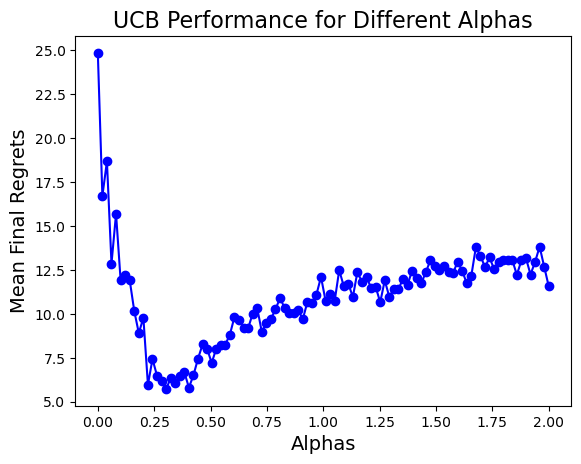

In [81]:
test_ucb_multiple_alpha(0, 2, 100)

Best alpha: 0.3181818181818182
Mean final regrets for the best alpha: 4.252999999999998


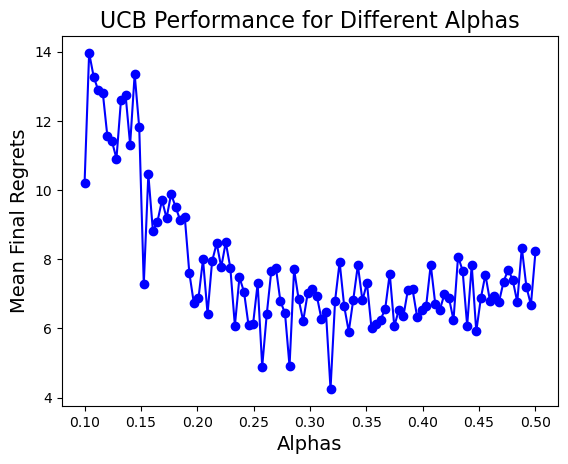

In [83]:
test_ucb_multiple_alpha(0.1, 0.5, 100)

### Task 1 (continued). Influence of the minimal gap (regret on different instances)

The function `RandomBernoulliBandit()` in `Stochastic_Bandits.py` allows to generate random Bernoulli bandit instance in which the gap between the best and second best arm has a certain value. 

Task: Visualize the regret for several instances with different values of the minimal gap $\Delta$, and comment on its influence on the regret.

In [22]:
nbArms = 2
timeHorizon = 1000
nExp = 100

tsave = np.arange(1, timeHorizon, 20)
learner = UCB(nbArms)

bandit1 = RandomBernoulliBandit(0.05, nbArms)

#TODO: complete the computation of regret for that and other values of delta 
### TODO 
def test_ucb_multiple_delta(start, stop, num):
    nbArms = 10
    regrets = {}
    N_exp = 500
    timeHorizon = 1000
    tsave = np.arange(1, timeHorizon, 20)
    learner = UCB(nbArms)
    
    deltas = np.linspace(start, stop, num=num)
    
    for delta in deltas:
        bandit = RandomBernoulliBandit(delta, nbArms)
        Regret = OneBanditOneLearnerMultipleRuns(bandit, learner, timeHorizon=timeHorizon, N_exp=N_exp, tsave=tsave)
        FinalRegret = Regret[:, -1]
        regrets[delta] = np.mean(FinalRegret)

    best_delta = min(regrets, key=lambda k: regrets[k])
    print("Best delta:", best_delta)
    print("Mean final regrets for the best delta:", regrets[best_delta])

    deltas_array = np.array(deltas)
    mean_regrets = np.array([regrets[delta] for delta in deltas])

    bandit1_005 = RandomBernoulliBandit(0.05, 2)
    regret = OneBanditOneLearnerMultipleRuns(bandit1_005, UCB(2), timeHorizon=1000, N_exp=100, tsave=np.arange(1, timeHorizon, 20))
    mean_005 = np.mean(regret[:, -1])

    plt.plot(deltas_array, mean_regrets, marker='o', linestyle='-', color='b')
    plt.scatter(0.05, mean_005, color='r', marker='o', label="Delta = 0.05")
    plt.xlabel("Deltas", fontsize=14)
    plt.ylabel("Mean Final Regrets", fontsize=14)
    plt.title("UCB Performance for Different Deltas", fontsize=16)
    plt.show()

#TODO: plot the regret 

Best delta: 0.9191919191919192
Mean final regrets for the best delta: 10.624371739211934


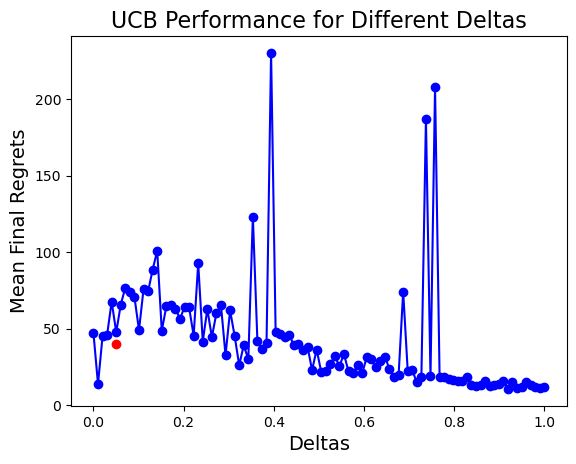

In [23]:
test_ucb_multiple_delta(0, 1, 100)

Globaly the regrets is higher the smaller the $\Delta$ 

On a MAB instance with bounded rewards, UCB (with parameter alpha = 1/2) is known to satisfy 

$$ \mathcal{R}_T \simeq  \sum_{a,\Delta_{a} > 0} \frac{\log(T)}{2\Delta_{a}} \simeq \frac{K-1}{\Delta}\log(T)$$

where $\Delta$ is the minimal gap. In the above experiment, we indeed observe that the regret usually increases when $\Delta$ gets smaller. But one can be more precise on what really influences the regret rate of a bandit algorithm (the gap between the best and second best arm is actually not enough to characterize the complexity!). 

## Part III) A Bayesian strategy: Thompson Sampling 

We now explore a completely different strategy based on a Bayesian idea: **Thompson Sampling**. This heuristic is very old (it was the first bandit paper proposed by Thompson in [1933](https://www.jstor.org/stable/2332286)), and its theoretical understanding is still quite partial beyond simple settings. Still, in the Bernoulli case, it is proved to be asymptotically optimal (see Chapter 36 of the [Lattimore and Szepesvari book](https://tor-lattimore.com/downloads/book/book.pdf) for a survey of results). 

The main idea of Thompson sampling is simple: before starting, the learner chooses a prior over a set of possible bandit environments. Then, at every round, the learner samples an environment according to the posterior at the current time and acts according to the optimal action in that environment. 

In the stochastic case, the algorithm works as follows: we start with a prior distribution on the mean reward of each arm. Then, at every time $t$, letting $\pi_a(t)$ denote the posterior distribution on arm $a$ after $t$ rounds, the algorithm draws a mean reward according to $\pi_a(t)$ for each arm and picks the arm leading to the highest mean reward: 

$$\forall a, \theta_a(t) \sim \pi_a(t-1), \ \ \ A_{t} = \underset{a}{\text{argmax }} \theta_a(t).$$

Then, the distribution for the selected arm is updated in a Baeysian manner with the observed reward. 

In the Bernoulli case, with a uniform (or more generally a Beta$(\alpha,\beta)$) prior distribution on each mean, the posterior distribution remains a Beta distribution. More precisely, one has

$$\pi_a(t) = \mathrm{Beta}\left(\alpha + S_a(t), \beta + N_a(t) - S_a(t)\right),$$

where $S_a(t)$ is the sum of rewards received from arm $a$ after $t$ rounds, and $N_a(t)$ is the number of selections of that arm, as before.

### Task 2. Implement Thompson Sampling for binary bandits with a Beta prior. 

In [49]:
## EXTRACT Task 2 (Thompson Sampling)

class ThompsonSampling:
    """Thompson Sampling with Beta(a,b) prior and Bernoulli likelihood"""
    def __init__(self, nbArms, a=1, b=1):
        # TODO 
        self.nbArms = nbArms
        self.alpha = a
        self.beta = b
        self.t = 0
        self.clear()

    def initPrior(self):
        # start uniformly
        self.prior = np.full(self.nbArms, 1/self.nbArms)

    def clear(self):
        # TODO 
        self.nbDraws = np.zeros(self.nbArms)
        self.cumRewards = np.zeros(self.nbArms)
        self.initPrior()
        self.posterior = self.prior.copy()
    
    def chooseArmToPlay(self):
        # TODO 
        return np.argmax(self.posterior)

    def updatePosterior(self):
        for arm in range(self.nbArms):
            alpha = self.alpha + self.cumRewards[arm]
            beta = self.beta + self.nbDraws[arm] - self.cumRewards[arm]
            self.posterior[arm] = np.random.beta(alpha, beta)
        

    def receiveReward(self, arm, reward):
        # TODO 
        self.cumRewards[arm] += reward
        self.nbDraws[arm] += 1
        self.t += 1
        # update posterior
        self.updatePosterior()

    def name(self):
        return "Thompson Sampling"

### Task 2 (continued) Compare this algorithm to UCB on a binary instance of your choice.

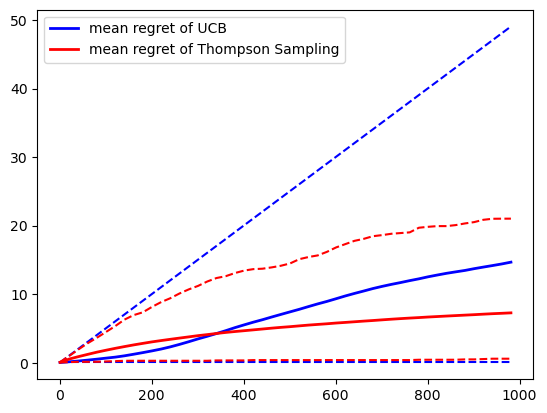

In [84]:
# TODO 
nbArms = 2
timeHorizon = 1000
nExp = 100

tsave = np.arange(1, timeHorizon, 20)

learner_ucb = UCB(nbArms)
learner_ths = ThompsonSampling(nbArms)

bandit = RandomBernoulliBandit(0.05, nbArms)

Regret_ucb = OneBanditOneLearnerMultipleRuns(bandit, learner_ucb, timeHorizon, nExp, tsave)
Regret_ths = OneBanditOneLearnerMultipleRuns(bandit, learner_ths, timeHorizon, nExp, tsave)

plt.clf()
plt.plot(tsave, np.mean(Regret_ucb, 0), linewidth=2.0, color="b", label="mean regret of "+learner_ucb.name())
plt.plot(tsave, np.quantile(Regret_ucb, 0.95, 0), tsave, np.quantile(Regret_ucb,0.05,0), linestyle="dashed", color="b")
plt.plot(tsave, np.mean(Regret_ths, 0), linewidth=2.0, color="r", label="mean regret of "+learner_ths.name())
plt.plot(tsave, np.quantile(Regret_ths, 0.95, 0), tsave, np.quantile(Regret_ths,0.05,0), linestyle="dashed", color="r")
plt.legend()
plt.show()

## Part III) EXP3

We finally explore the EXP3 algorithm. The EXP3 algorithm was proposed for adversarial bandits, but we will test it here using the stochastic bandits that we have seen above. 

EXP3 was originally proposed by [Auer et al., 1995](https://www.computer.org/csdl/proceedings-article/focs/1995/71830322/12OmNAYGlx6) and subsequently much used, refined and analyzed. An accessible presentation can be found in Chapter 11 of [Lattimore and Szepesvari's book](https://tor-lattimore.com/downloads/book/book.pdf). 

The idea of EXP3 is to use exponential weights based on an importance sampling estimate of the reward of each arm. Specifically, the algorithm does the following steps: 
- Initialize $\hat{S}_{0,i} = 0$ for all arms $i$
- For t = 1...n, 
    - calculate the distribution $P$ as $$P_{ti} = \frac{\exp(\eta \hat{S}_{t-1,i})}{\sum_i \exp(\eta \hat{S}_{t-1,i})}$$
    - sample the arm $A_t$ at time $t$ according to this distribution
    - upon receiving reward $X_t$ after drawing arm $A_t$, update the estimates of every arm using the loss-based importance-weighted estimator: $$\hat{S}_{t,i} = \hat{S}_{t-1,i} + 1 - \frac{1_{A_t = i}\cdot(1 - X_t)}{P_{ti}}$$
    
    
Here $\eta$ is a parameter called the learning rate. We assume that it is constant (i.e., does not depend on $t$). Note that we also assumed that the reward is in $[0, 1]$.

### Task 3. Implement EXP3 with $\eta$ as a parameter. 

Make sure to use the `eta` parameter as supplied to the function `__init__`. 

In [133]:
## EXTRACT Task 3 (Exp)

class EXP3:
    
    """EXP3 algorithm with parameter eta"""
    def __init__(self, nbArms, eta=1):
        # TODO 
        self.nbArms = nbArms
        self.eta = eta
        self.clear()

    def clear(self):
        # TODO 
        self.nbDraws = np.zeros(self.nbArms)
        self.cumRewards = np.zeros(self.nbArms)
        self.S = np.zeros(self.nbArms)
        self.P = np.zeros(self.nbArms)
        self.t = 0
    
    def chooseArmToPlay(self):
        # TODO 
        self.P = np.exp(self.eta * self.S)
        sum = np.sum(self.P)
        self.P /= sum
        self.P[self.P < 1e-9] = 0.0
        self.P[(self.P > 1-1e-9) | np.isinf(self.P) | np.isnan(self.P)] = 1.0
        return np.random.choice([arm for arm in range(self.nbArms)], p=self.P)

    def updateS(self, arm):
        self.S += 1
        if(self.P[arm] != 0):
            self.S[arm] -= (1 - self.cumRewards[arm]) / self.P[arm]
        
    def receiveReward(self, arm, reward):
        # TODO 
        self.cumRewards[arm] += reward
        self.nbDraws[arm] += 1
        self.t += 1
        self.updateS(arm)

    def name(self):
        return "EXP3"

### Task 3 (continued). Compare EXP3 to UCB and Thomson sampling on a Bernoulli bandit


/tmp/ipykernel_20463/2713942274.py:22: RuntimeWarning: overflow encountered in exp
  self.P = np.exp(self.eta * self.S)
/tmp/ipykernel_20463/2713942274.py:24: RuntimeWarning: invalid value encountered in divide
  self.P /= sum


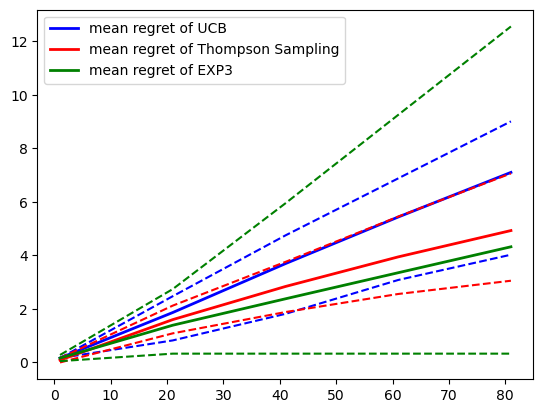

In [136]:
# TODO 

nbArms = 4
timeHorizon = 100
nExp = 500

tsave = np.arange(1, timeHorizon, 20)

learner_ucb = UCB(nbArms)
learner_ths = ThompsonSampling(nbArms)
learner_exp = EXP3(nbArms)

bandit = RandomBernoulliBandit(0.05, nbArms)

Regret_ucb = OneBanditOneLearnerMultipleRuns(bandit, learner_ucb, timeHorizon, nExp, tsave)
Regret_ths = OneBanditOneLearnerMultipleRuns(bandit, learner_ths, timeHorizon, nExp, tsave)
Regret_exp = OneBanditOneLearnerMultipleRuns(bandit, learner_exp, timeHorizon, nExp, tsave)

plt.clf()
plt.plot(tsave, np.mean(Regret_ucb, 0), linewidth=2.0, color="b", label="mean regret of "+learner_ucb.name())
plt.plot(tsave, np.quantile(Regret_ucb, 0.95, 0), tsave, np.quantile(Regret_ucb,0.05,0), linestyle="dashed", color="b")
plt.plot(tsave, np.mean(Regret_ths, 0), linewidth=2.0, color="r", label="mean regret of "+learner_ths.name())
plt.plot(tsave, np.quantile(Regret_ths, 0.95, 0), tsave, np.quantile(Regret_ths,0.05,0), linestyle="dashed", color="r")
plt.plot(tsave, np.mean(Regret_exp, 0), linewidth=2.0, color="g", label="mean regret of "+learner_exp.name())
plt.plot(tsave, np.quantile(Regret_exp, 0.95, 0), tsave, np.quantile(Regret_exp,0.05,0), linestyle="dashed", color="g")
plt.legend()
plt.show()

### Bonus task: investigate the impact of the importance weighted estimator used and of the parameter $\eta$.

## Part IV. A Quiz.

There is a pdf sheet associated with the lab with some quiz questions relating to bandits, as covered in the lecture. Replace the blanks ('_') in the `answers` dictionary, such that answers[1] is one of 'a', 'b', 'c', 'd', 'e', 'f' (and so on, for the other questions).

In [ ]:
## EXTRACT Quiz answers

answers = {
    1 : ['b', 'e'],
    2 : ['a', 'b', 'c'], 
    3 : ['a', 'b', 'c', 'd'], 
    4 : ['a', 'b', 'c', 'e'], 
    5 : ['a', 'c'], 
    6 : ['a', 'd', 'e'],
    7 : ['a', 'c', 'e']
}

# 